In [1]:
import os
import mido
import numpy as np
import matplotlib.pyplot as plt


In [2]:
import mido

def createMidiFileWithAllMessages(notes, duration=200, wait_time = 0, filename='test.mid'):
    mid = mido.MidiFile()
    track = mido.MidiTrack()
    mid.tracks.append(track)

    for note in notes:
        track.append(mido.Message('note_on', note=note, velocity=64, time=wait_time))
        track.append(mido.Message('note_off', note=note, velocity=0, time=duration))

    mid.save(filename.removesuffix('.mid') + '.mid')


notes = range(50, 80) 

createMidiFileWithAllMessages(notes)

In [3]:
print('catch all the data')

def get_midis():
    ms = []
    directory = "data"
    for foldername in os.listdir(directory):
        directory = os.path.join("data", foldername)
        for filename in os.listdir(directory):
            if('V2'in filename): continue
            if os.path.isfile(os.path.join(directory, filename)):
                ms.append(os.path.join(directory, filename))
                # print(filename)
    return ms

midis = get_midis()
print(midis[:10])
# works only with files with just one track
def get_all_notes_one_file(midi_file):
    file = mido.MidiFile(midi_file)
    track = file.tracks[1]
    messages = []
    for message in track:
        if(message.type == 'note_on'):
            messages.append(message)
    
    notes = [0] + [m.note for m in messages] + [1]
    # print(notes)
    return notes

all_notes_all_files = [get_all_notes_one_file(m) for m in midis]

print(len(all_notes_all_files))

catch all the data
['data\\albeniz\\alb_esp1.mid', 'data\\albeniz\\alb_esp2.mid', 'data\\albeniz\\alb_esp3.mid', 'data\\albeniz\\alb_esp4.mid', 'data\\albeniz\\alb_esp5.mid', 'data\\albeniz\\alb_esp6.mid', 'data\\albeniz\\alb_se1.mid', 'data\\albeniz\\alb_se2.mid', 'data\\albeniz\\alb_se3.mid', 'data\\albeniz\\alb_se4.mid']
295


In [4]:
X_values = np.concatenate(all_notes_all_files)
print(X_values.shape)

# notes

n = np.unique(X_values, return_counts=True)
notes_extreme = n[0][n[1] < 100]
print('notes extreme to remove : ', notes_extreme)
X_values = X_values[~np.isin(X_values, notes_extreme)]

nunique = np.unique(X_values, return_counts=True)

# Tokenize the data

tokenToVals = nunique[0]

ValsToToken = {v:i for i, v in enumerate(tokenToVals)}
vocab_size = len(tokenToVals)

X = np.array([ValsToToken[x] for x in X_values])
a = np.random.randint(0, len(tokenToVals), 10)

print(X[:10])


(763088,)
notes extreme to remove :  [ 24  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  42 104
 105 106 107]
[ 0 41 41 48 48 46 46 48 48 46]


## Training

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

block_size = 128
batch_size = 64
n_embd = 192 # be a multiple of n_head
dropout = 0.2
n_heads = 6 # be a divisible of n_embd
vocab_size = len(tokenToVals) # ~= 1800
n_layer = 4
eval_iters = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
X = torch.tensor([ValsToToken[x] for x in X_values], dtype=torch.long, device=device)
n = int(0.9*len(X))
X_train = X[:n]
X_val = X[n:]

# Single head self-attention
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out
# multi-head self-attention
class MultiHead(nn.Module):
    """ multi-head self-attention """

    def __init__(self, n_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(n_heads)])
        self.proj = nn.Linear(n_heads * head_size, n_embd)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, channels)
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out
# feed-forward layer
class FeedForward(nn.Module):
    """ a simple linear layer followed by a non-linearity """
    
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, n_embd * 4),
            nn.ReLU(),
            nn.Linear(n_embd * 4, n_embd),
            nn.Dropout()
        )
        
    def forward(self, x):
        out = self.net(x)
        return out
# block
class Block(nn.Module):
    """ a transformer Block """
    
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.MultiHeads = MultiHead(n_heads, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
        
    def forward(self, x):
        x = x + self.MultiHeads(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x
# transformer
class Transformer(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_heads) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)
        
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        
    def forward(self, idx, targets=None):
        # print('oouais', idx.shape)
        B, T = idx.shape
        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        # pos_emb = self.position_embedding_table(torch.arange(T)) # (T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss
    
    
    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:] # (B, T)
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx


model = Transformer()
model = model.to(device)


In [7]:
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = X_train if split == 'train' else X_val
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            # print(X.shape,Y.shape)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    # print(out)
    return out

1826752 parameters


c:\Users\lorra\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\lorra\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


step 0: train loss 4.1713, val loss 4.1654	lr : 0.05	 best val loss : 4.1654|at : 0
step 400: train loss 3.2730, val loss 3.2939	lr : 0.05	 best val loss : 3.2939|at : 400
step 800: train loss 3.2222, val loss 3.2420	lr : 0.05	 best val loss : 3.2420|at : 800
step 1200: train loss 3.1363, val loss 3.1522	lr : 0.05	 best val loss : 3.1522|at : 1200
step 1600: train loss 3.1478, val loss 3.1883	lr : 0.05	 best val loss : 3.1522|at : 1200
step 2000: train loss 3.2896, val loss 3.3274	lr : 0.05	 best val loss : 3.1522|at : 1200
step 2400: train loss 3.2745, val loss 3.2650	lr : 0.05	 best val loss : 3.1522|at : 1200
step 2800: train loss 3.2055, val loss 3.2246	lr : 0.05	 best val loss : 3.1522|at : 1200
step 3200: train loss 3.2411, val loss 3.2438	lr : 0.05	 best val loss : 3.1522|at : 1200
step 3600: train loss 3.1596, val loss 3.1965	lr : 0.05	 best val loss : 3.1522|at : 1200
step 4000: train loss 3.2248, val loss 3.2538	lr : 0.05	 best val loss : 3.1522|at : 1200
step 4400: train los

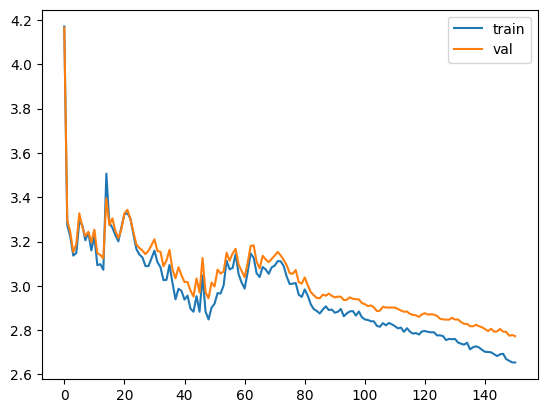

In [8]:
import torch.optim.lr_scheduler as lr_scheduler

max_iters = 5000
eval_interval = 200
lossi = []
learning_rate = 0.05
best_val_loss = float('inf')
stepBestVal = 0
print(sum(p.numel() for p in model.parameters()), 'parameters')

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.3)
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8, verbose=True)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_iters, eta_min=0, last_epoch=-1)
for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        lossi.append(losses)

        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}\tlr : {optimizer.param_groups[0]['lr']}\t best val loss : {best_val_loss:.4f}|at : {stepBestVal}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    scheduler.step()


# save the model
torch.save(model.state_dict(), 'model1.pth')

print(lossi)
plt.plot([l['train'] for l in lossi], label='train')
plt.plot([l['val'] for l in lossi], label='val')
plt.legend()
plt.show()
# converting it back to music



In [9]:
decode = lambda x: [tokenToVals[i] for i in x]
context = torch.zeros((1,1), dtype=torch.long, device=device)
print(decode(model.generate(context, max_new_tokens=100)[0].tolist()))

def tokensToMidi(tokens):
    vals = decode(tokens)
    print(vals)
    notes = []
    for t in vals:
        # print(type(t))
        if(np.equal(t, 0)): continue
        notes.append(t)
    createMidiFileWithAllMessages(notes, filename='test.mid')


gen1 = model.generate(context, max_new_tokens=100)[0].tolist()


print(gen1)
tokensToMidi(gen1)

[0, 59, 57, 71, 62, 67, 59, 63, 64, 62, 67, 63, 60, 61, 72, 0, 72, 60, 60, 62, 60, 60, 62, 63, 58, 60, 60, 60, 60, 59, 67, 62, 61, 55, 67, 55, 60, 61, 58, 58, 70, 61, 55, 63, 62, 54, 58, 65, 59, 67, 63, 58, 60, 60, 61, 62, 68, 55, 58, 60, 58, 58, 56, 55, 59, 65, 50, 52, 67, 67, 67, 67, 67, 65, 62, 62, 64, 59, 55, 61, 62, 60, 59, 59, 67, 67, 52, 54, 59, 60, 65, 60, 60, 57, 56, 46, 64, 55, 67, 60, 69]
[0, 24, 20, 25, 21, 29, 27, 19, 25, 42, 23, 27, 15, 54, 56, 21, 23, 18, 15, 16, 27, 23, 35, 28, 34, 30, 30, 35, 32, 35, 27, 56, 51, 40, 35, 35, 35, 35, 35, 35, 42, 39, 28, 35, 35, 28, 41, 35, 38, 47, 39, 33, 45, 20, 21, 15, 19, 19, 21, 32, 41, 35, 23, 23, 23, 19, 22, 39, 40, 30, 32, 27, 23, 27, 25, 29, 30, 33, 32, 28, 30, 30, 30, 28, 34, 32, 32, 27, 47, 27, 43, 59, 37, 33, 31, 40, 43, 42, 39, 28, 40]
[0, 64, 60, 65, 61, 69, 67, 59, 65, 82, 63, 67, 55, 94, 96, 61, 63, 58, 55, 56, 67, 63, 75, 68, 74, 70, 70, 75, 72, 75, 67, 96, 91, 80, 75, 75, 75, 75, 75, 75, 82, 79, 68, 75, 75, 68, 81, 75, 7